# Rapport de classification

Ce rapport détaille l'approche suivie pour la construction d'un modèle prédictif permettant d'estimer une caractéristique socio-économique des individus en France métropolitaine.


## 1. Introduction

Nous avons accès à un ensemble de données décrivant divers aspects socio-économiques des individus, répartis entre un ensemble d'apprentissage (train) et un ensemble de test. L'objectif est de construire un modèle permettant de prédire une variable cible en utilisant les autres variables disponibles.

## 2. Chargement des données

Nous devons d'abord charger les différentes sources de données et les assembler en une seule base exploitable.

In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
from functools import reduce
import numpy as np 
import pandas as pd 
import seaborn as sns


import phik
import matplotlib.pyplot as plt 
from additional import evaluate_model
from catboost import CatBoostClassifier
import optuna

In [100]:


# Charger les datasets principaux
train_df = pd.read_csv("data/learn_dataset.csv")
emp_type_df = pd.read_csv("data/learn_dataset_emp_type.csv")
job_df = pd.read_csv("data/learn_dataset_job.csv")
retired_former_df = pd.read_csv("data/learn_dataset_retired_former.csv")
retired_jobs_df = pd.read_csv("data/learn_dataset_retired_jobs.csv")
retired_pension_df = pd.read_csv("data/learn_dataset_retired_pension.csv")
sport_df = pd.read_csv("data/learn_dataset_sport.csv")

# dfs = [train_df, emp_type_df , job_df, retired_former_df, retired_jobs_df, retired_pension_df, sport_df] 
df_base = train_df.merge(job_df, on='PRIMARY_KEY', how='inner')\
             .merge(emp_type_df, on='PRIMARY_KEY', how='left')\
             .merge(sport_df, on='PRIMARY_KEY', how='left')
             


#df = reduce(lambda left, right: pd.merge(left, right, on='PRIMARY_KEY', how='left'), dfs)



df_base.to_csv("merged_dataset.csv", index=False)
df_base.shape

(19324, 22)

## 3. Exploration et nettoyage des données

Nous allons analyser la structure des données, détecter les valeurs manquantes et gérer les incohérences éventuelles.

In [67]:
def spit_job_desc(df):    
    return df.insert(df.columns.get_loc('job_desc') + 1, 'job_desc_n1', df['job_desc'].astype(str).str[0])

def num_to_cat(df_:pd.DataFrame, columns)->pd.DataFrame:
    df = df_.copy()
    for column in columns:
        if column in df.columns:
            deciles, bins = pd.qcut(df[column], q=10, labels=False, retbins=True, duplicates='drop')
            decile_labels = [f"{int(bins[i])}_to_{int(bins[i+1])}" for i in range(len(bins)-1)]

            df[column] = deciles.map(lambda d: decile_labels[int(d)] if pd.notnull(d) else d)
    return df

def transform_y(y:pd.Series):
    if y.name != 'target':
        raise ValueError("transform_y(y) y column is not 'target' ")
    return y.apply(lambda x : 0 if x == 'A' else 1)




In [68]:
#df = split_job_desc(df)
df_base.head(10)

,PRIMARY_KEY,INSEE,Household_type,JOB_42,Highest_degree,Studying,AGE_2019,act,sex,target,...,company_category,Work_condition,ECO_SECT,job_desc,employee_count,Job_dep,remuneration,job_category,emp_type,sports
0,9,01004,TYPEMR|4|1,csp_5_4,dip|1|6,False,46,ACT1.1,Female,A,...,ct_8,C,OZ,545d,tr_6,01,24805,O,EMP1.6,NaN
1,11,01004,TYPEMR|4|1,csp_6_7,dip|1|3,False,33,ACT1.1,Male,E,...,ct_9,C,CG,674a,tr_5,01,22962,O,EMP1.6,NaN
2,20,01004,TYPEMR|4|1,csp_5_3,dip|1|2,False,24,ACT1.1,Male,A,...,ct_1,N,OZ,532c,tr_6,36,10594,O,EMP1.5,CF-401
3,22,01004,TYPEMR|4|1,csp_4_3,dip|1|7,False,23,ACT1.1,Female,A,...,ct_9,C,QA,431f,tr_6,01,29058,O,EMP1.5,NaN
4,33,01007,TYPEMR|4|1,csp_5_5,dip|3,False,43,ACT1.1,Male,E,...,ct_9,C,GZ,552a,tr_5,69,20569,O,EMP1.6,CF-211
5,37,01009,TYPEMR|4|3,csp_6_3,dip|1|5,False,30,ACT1.1,Female,A,...,ct_9,C,IZ,636d,tr_1,69,13112,O,EMP1.6,CF-135
6,40,01010,TYPEMR|1|2,csp_4_3,dip|1|7,False,59,ACT1.1,Female,E,...,ct_8,C,QB,434a,tr_4,71,42271,O,EMP1.6,NaN
7,48,01014,TYPEMR|4|1,csp_5_3,dip|1|6,False,45,ACT1.1,Male,A,...,ct_9,C,NZ,534a,tr_5,69,6183,O,EMP1.6,NaN
8,54,01021,TYPEMR|4|1,csp_6_3,dip|1|3,False,30,ACT1.1,Male,A,...,ct_9,C,FZ,632a,tr_2,01,23064,O,EMP1.6,NaN
9,65,01026,TYPEMR|4|2,csp_5_2,dip|1|7,False,45,ACT1.1,Male,E,...,ct_9,C,QA,526e,tr_1,01,30912,O,EMP1.6,NaN


/opt/anaconda3/lib/python3.12/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable act for analysis 1. Dropping this column
  warnings.warn(


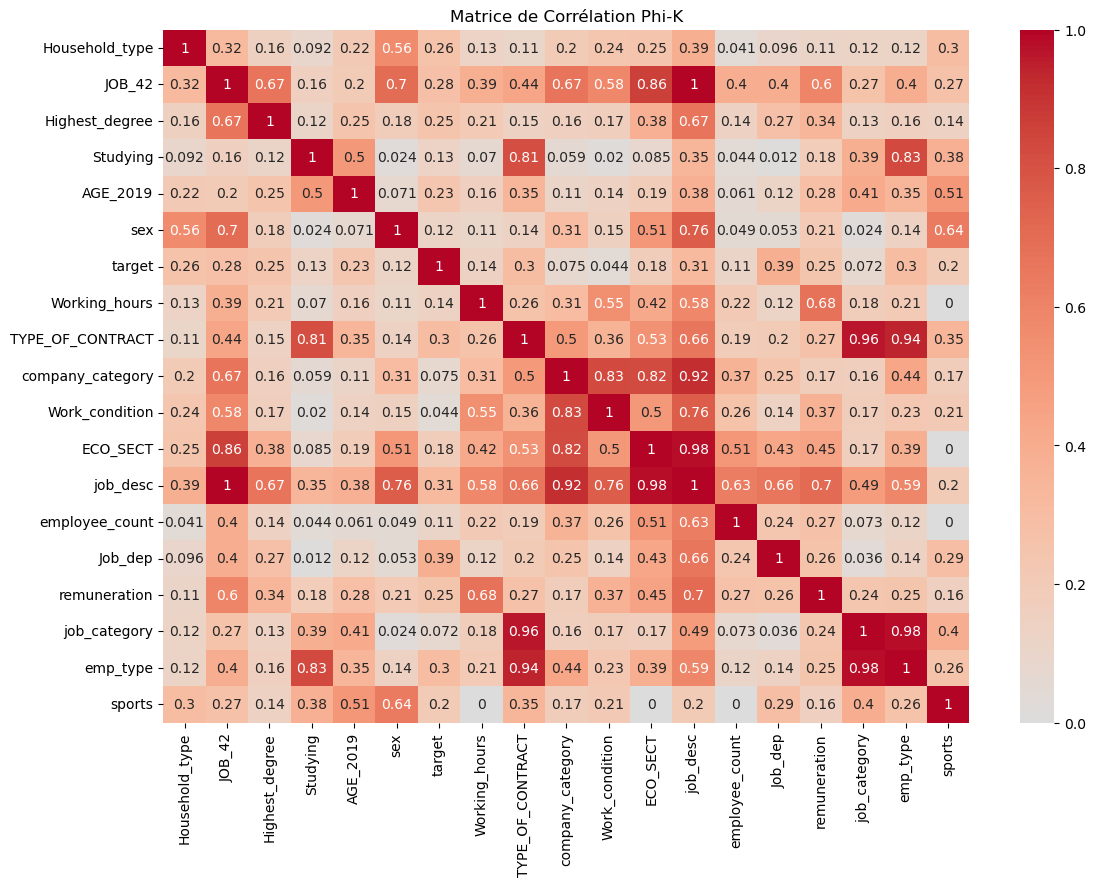

In [ ]:
# corr_df = df[['job_category','sports','target','emp_type','act','Work_condition','Job_dep','Household_type','JOB_42','sex','Studying','Highest_degree','ECO_SECT','AGE_2019']]

df_corr_matrix = num_to_cat(df_base, columns=['AGE_2019', 'Working_hours', 'remuneration'])

df_corr_matrix = df_corr_matrix.drop(columns=['PRIMARY_KEY','INSEE'])
# apres étude on élimine les colonnes suivantes pour simplifier l'étude)

corr_matrix = df_corr_matrix.phik_matrix()
# corr_matrix = df_corr_matrix.drop(columns=["Studying","job_desc","job_category","TYPE_OF_CONTRACT","ECO_SECT"]).phik_matrix()



plt.figure(figsize=(13, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de Corrélation Phi-K")
plt.show()


In [15]:
df_corr_matrix.head()

,Household_type,JOB_42,Highest_degree,Studying,AGE_2019,act,sex,target,Working_hours,TYPE_OF_CONTRACT,company_category,Work_condition,ECO_SECT,job_desc,employee_count,Job_dep,remuneration,job_category,emp_type,sports
0,TYPEMR|4|1,csp_5_4,dip|1|6,False,43_to_47,ACT1.1,Female,A,1923_to_3000,CDI,ct_8,C,OZ,545d,tr_6,01,23088_to_26584,O,EMP1.6,NaN
1,TYPEMR|4|1,csp_6_7,dip|1|3,False,31_to_35,ACT1.1,Male,E,1669_to_1773,CDI,ct_9,C,CG,674a,tr_5,01,20324_to_23088,O,EMP1.6,NaN
2,TYPEMR|4|1,csp_5_3,dip|1|2,False,15_to_27,ACT1.1,Male,A,NaN,AUT,ct_1,N,OZ,532c,tr_6,36,6134_to_10837,O,EMP1.5,CF-401
3,TYPEMR|4|1,csp_4_3,dip|1|7,False,15_to_27,ACT1.1,Female,A,1820_to_1923,CDD,ct_9,C,QA,431f,tr_6,01,26584_to_31819,O,EMP1.5,NaN
4,TYPEMR|4|1,csp_5_5,dip|3,False,39_to_43,ACT1.1,Male,E,1820_to_1923,CDI,ct_9,C,GZ,552a,tr_5,69,20324_to_23088,O,EMP1.6,CF-211


## 4. Préparation des données

Nous devons convertir les variables catégoriques en valeurs numériques et traiter les valeurs manquantes.

In [101]:

# drop(columns=["Studying","job_desc","job_category","TYPE_OF_CONTRACT","ECO_SECT"])

numerical_features = ["AGE_2019","Working_hours","remuneration"]
categorical_features = ["Household_type", "JOB_42", "sex", "Work_condition","employee_count","Job_dep","emp_type","sports"]
ordinal_features = ["Highest_degree", "company_category"] #"act"
ordinal_categories = [
    ["dip|1", "dip|2", "dip|3", "dip|1|1", "dip|1|2", "dip|1|3", "dip|1|4", "dip|1|5", "dip|1|6", "dip|1|7", "dip|1|8", "dip|1|9"],
    #["ACT1.1","ACT1.2","ACT2.1","ACT2.2","ACT2.3","ACT2.4","ACT2.5",], # TODO better encoding
    ["ct_1","ct_2","ct_3","ct_4","ct_5","ct_6","ct_7","ct_8","ct_9"]
    ]
target = ["target"]

In [102]:
print(cat_features)

['Household_type', 'job_desc', 'Highest_degree', 'act', 'sex', 'company_category', 'Work_condition', 'employee_count', 'Job_dep', 'emp_type', 'sports']


In [ ]:
df = df_base.copy()
df["hourly_rate"] = df['remuneration']/df['Working_hours'] # attention aux valeures manquantes, ou division nulle


df = df.drop(columns=['PRIMARY_KEY','INSEE',"Studying","JOB_42","job_category","TYPE_OF_CONTRACT","ECO_SECT"])

cat_features = ['Household_type', 'job_desc', 'Highest_degree', 'act', 'sex', 'company_category',
                'Work_condition', 'employee_count', 'Job_dep', 'emp_type', 'sports']

num_features = ["AGE_2019","Working_hours","remuneration","hourly_rate"]

df[cat_features] = df[cat_features].fillna('missing')
df[num_features] = df[num_features].fillna(0)
df



,Household_type,Highest_degree,AGE_2019,act,sex,target,Working_hours,company_category,Work_condition,job_desc,employee_count,Job_dep,remuneration,emp_type,sports,hourly_rate
0,TYPEMR|4|1,dip|1|6,46,ACT1.1,Female,A,1935.0,ct_8,C,545d,tr_6,01,24805,EMP1.6,missing,12.819121
1,TYPEMR|4|1,dip|1|3,33,ACT1.1,Male,E,1697.0,ct_9,C,674a,tr_5,01,22962,EMP1.6,missing,13.530937
2,TYPEMR|4|1,dip|1|2,24,ACT1.1,Male,A,0.0,ct_1,N,532c,tr_6,36,10594,EMP1.5,CF-401,0.000000
3,TYPEMR|4|1,dip|1|7,23,ACT1.1,Female,A,1852.0,ct_9,C,431f,tr_6,01,29058,EMP1.5,missing,15.690065
4,TYPEMR|4|1,dip|3,43,ACT1.1,Male,E,1912.0,ct_9,C,552a,tr_5,69,20569,EMP1.6,CF-211,10.757845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19319,TYPEMR|4|1,dip|1|6,48,ACT1.1,Female,E,1820.0,ct_9,C,372c,tr_4,75,50445,EMP1.6,missing,27.717033
19320,TYPEMR|1|1,dip|1|8,36,ACT1.1,Male,A,1820.0,ct_9,C,383a,tr_6,95,36902,EMP1.6,CF-123,20.275824
19321,TYPEMR|3|1,dip|1|7,43,ACT1.1,Male,A,1711.0,ct_9,C,388c,tr_4,75,42494,EMP1.6,missing,24.835769
19322,TYPEMR|4|1,dip|1|7,38,ACT1.1,Female,E,1775.0,ct_9,C,372c,tr_6,75,51628,EMP1.6,missing,29.086197


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

target_encoder = LabelEncoder()

X = df.drop(columns='target')
y = pd.Series(target_encoder.fit_transform(df['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [105]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_preds = iso_forest.fit_predict(X_train[num_features])  # Utilisation des variables encodées

# Garder uniquement les données normales
X_train_clean = X_train[outlier_preds == 1]
y_train_clean = y_train[outlier_preds == 1]


In [112]:
print(f"perte : {(1 - X_train_clean.shape[0]/ X_train.shape[0])*100:.4} %, reste : {X_train_clean.shape[0]} lignes")

perte : 10.0 %, reste : 13913 lignes


On voit qu'on pert 10% d'outliers

In [113]:
model_cb = CatBoostClassifier(iterations=100, depth=6, cat_features=cat_features, verbose=0)


model_cb.fit(X_train, y_train)

In [57]:
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 0,
        'cat_features': cat_features,  # Passer explicitement les features catégorielles
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

In [59]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)

# Affichage des meilleurs paramètres
print("Best parameters:", study.best_params)


[I 2025-03-31 18:27:03,900] A new study created in memory with name: no-name-79419674-6108-45a0-bfb7-aabb697832b2
[I 2025-03-31 18:27:06,594] Trial 2 finished with value: 0.7764553686934024 and parameters: {'iterations': 121, 'depth': 4, 'learning_rate': 0.16908983534178917, 'l2_leaf_reg': 0.12532841136870532, 'border_count': 237, 'random_strength': 0.49200672802432244, 'bagging_temperature': 0.4176175716061924}. Best is trial 2 with value: 0.7764553686934024.
[I 2025-03-31 18:27:25,218] Trial 7 finished with value: 0.7880983182406209 and parameters: {'iterations': 256, 'depth': 4, 'learning_rate': 0.11589127229836167, 'l2_leaf_reg': 0.04831490604637645, 'border_count': 217, 'random_strength': 0.49969360305070065, 'bagging_temperature': 0.7735647779489346}. Best is trial 7 with value: 0.7880983182406209.
[I 2025-03-31 18:27:28,431] Trial 0 finished with value: 0.7958602846054333 and parameters: {'iterations': 204, 'depth': 6, 'learning_rate': 0.09648300073438436, 'l2_leaf_reg': 1.05099

Best parameters: {'iterations': 941, 'depth': 5, 'learning_rate': 0.06265697342904956, 'l2_leaf_reg': 0.0072987439915125785, 'border_count': 38, 'random_strength': 0.0026994802917267207, 'bagging_temperature': 0.6711860095321492}


In [116]:
# Entraîner le modèle final avec les meilleurs hyperparamètres
# best_params = {'iterations': 941, 'depth': 5, 'learning_rate': 0.06265697342904956, 'l2_leaf_reg': 0.0072987439915125785, 'border_count': 38, 'random_strength': 0.0026994802917267207, 'bagging_temperature': 0.6711860095321492}

best_model_cb = CatBoostClassifier(**study.best_params)
best_model_cb.fit(X_train_clean, y_train_clean, cat_features=cat_features, verbose=0)

🔹 R² Score: 0.1231
🔹 MAE: 0.2163
🔹 MSE: 0.2163

📊 Rapport de Classification:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      2156
           1       0.75      0.76      0.76      1709

    accuracy                           0.78      3865
   macro avg       0.78      0.78      0.78      3865
weighted avg       0.78      0.78      0.78      3865



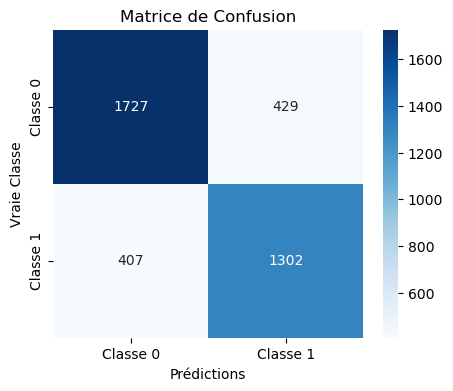

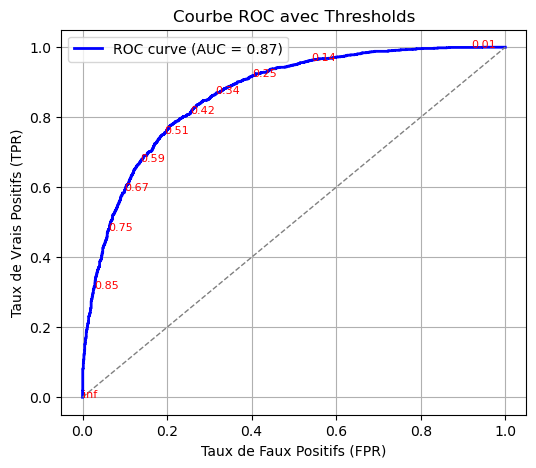

In [117]:
evaluate_model(best_model_cb, X_test, y_test)
# evaluate_model(best_model, X_train, y_train)


In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import FunctionTransformer

def make_pipeline(model):
    return Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features), 
            ("cat", Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')), 
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features), 
            ("ord", Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder(categories=ordinal_categories)) 
            ]), ordinal_features)
        ])),
        ("model", model)
    ])



# 5.Entrainement de models

In [ ]:
from sklearn.model_selection import train_test_split

target_encoder = LabelEncoder()

X = df.drop(columns='target')
y = pd.Series(target_encoder.fit_transform(df['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train = pd.Series(target_encoder.fit_transform(y_train))


In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
from sklearn.linear_model import LogisticRegression

stratKfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search pour optimiser l'hyperparamètre "C" (régularisation)
glm_param_grid = {
    "model__solver": ['liblinear'],
    "model__penalty" : ['l2'],
    "model__C" : np.linspace(0.10, 0.40, 8),
    "model__fit_intercept": [True],
    "model__class_weight": [None]
}

glm_pipeline = make_pipeline(LogisticRegression(max_iter=1000, random_state=42))

grid_search = GridSearchCV(glm_pipeline, glm_param_grid, cv=stratKfold, refit='r2', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)
# grid_search = RandomizedSearchCV(glm_pipeline, glm_param_grid, cv=stratKfold, n_iter=100, refit='r2', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

In [11]:

pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_r2").transpose()


,4,5,7,6,2,3,1,0
mean_fit_time,0.553407,0.51734,0.376368,0.468316,0.549447,0.558939,0.477488,0.424586
std_fit_time,0.024834,0.009364,0.022272,0.029535,0.030901,0.00659,0.066008,0.010814
mean_score_time,0.079299,0.05421,0.027159,0.031232,0.062097,0.065717,0.095401,0.06674
std_score_time,0.006676,0.014164,0.000823,0.002007,0.004119,0.00448,0.02695,0.014977
param_glm__C,0.271429,0.314286,0.4,0.357143,0.185714,0.228571,0.142857,0.1
param_glm__class_weight,None,None,None,None,None,None,None,None
param_glm__fit_intercept,True,True,True,True,True,True,True,True
param_glm__penalty,l2,l2,l2,l2,l2,l2,l2,l2
param_glm__solver,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
params,"{'glm__C': 0.27142857142857146, 'glm__class_we...","{'glm__C': 0.31428571428571433, 'glm__class_we...","{'glm__C': 0.4, 'glm__class_weight': None, 'gl...","{'glm__C': 0.3571428571428572, 'glm__class_wei...","{'glm__C': 0.18571428571428572, 'glm__class_we...","{'glm__C': 0.2285714285714286, 'glm__class_wei...","{'glm__C': 0.14285714285714288, 'glm__class_we...","{'glm__C': 0.1, 'glm__class_weight': None, 'gl..."


### Démarche de tuning d'hyper parametres avez gridSearch :


A Chaques experiences, on rédige un jeu de paramètres à tester, et on déduit lesquels garder en fonction du CV_results.

Si le produit cartésient (l'ensemble de combinaison) des paramètres est trop grand, on réduit le nombre de folds pour accélerer l'algo.

On choisit le paramètre étudié avec le meilleur score+std (on veux que les résultats entres folds ne varient peu pour garder une généralisation)

-> Process :

1. On commence par mettre tous les paramètres interessant et leurs des valeurs coherentes en vue du contexte. (Solver, pénalité, intercept, classes balancées...)

 - on execute un randomized, pour equarter les configurations evidantes.
 - on affine et décide de quels parametres garder

2. Pour les paramètres "importants" ici C, on effectue un GridSearch avec un jeu de paremètres restreits
   
 - sur des bornes larges, puis de plus en plus sérées



## Evaluation du modèle linéaire

🔹 R² Score: -0.0133
🔹 MAE: 0.2499
🔹 MSE: 0.2499

📊 Rapport de Classification:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78      2156
           1       0.72      0.71      0.72      1709

    accuracy                           0.75      3865
   macro avg       0.75      0.75      0.75      3865
weighted avg       0.75      0.75      0.75      3865



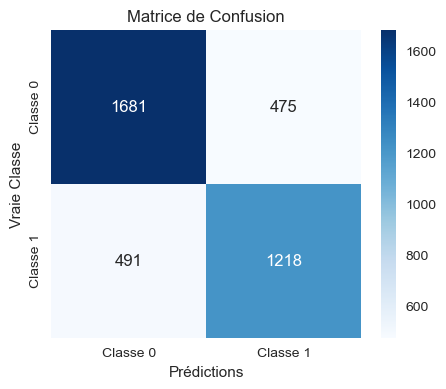

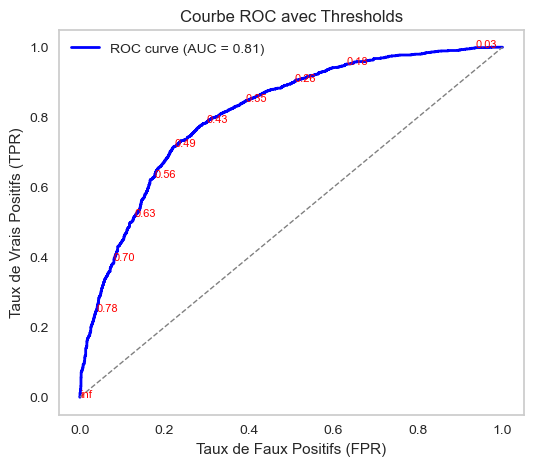

In [22]:
evaluate_model(best_model, X_test, y_test)

## 5. Sélection des modèles

Nous allons tester plusieurs modèles de classification, notamment une régression logistique et une forêt aléatoire.

In [ ]:
from sklearn.neural_network import MLPClassifier
# from torch import mlp...|
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import xgb

In [99]:
from sklearn.ensemble import RandomForestClassifier

stratKfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search pour optimiser l'hyperparamètre "C" (régularisation)
rf_param_grid = {
    'model__n_estimators': [50],  # Nombre d'arbres dans la forêt
    'model__max_depth': [10, 20],  # Profondeur maximale des arbres
    'model__min_samples_split': [5, 10],  # Nombre minimal d'échantillons pour diviser un noeud
    'model__min_samples_leaf': [2],  # Nombre minimal d'échantillons dans une feuille
    'model__max_features': ['log2', 'sqrt'],  # Nombre maximal de features à considérer lors de la division
    # 'model__bootstrap': [True],  # Si la sélection des échantillons pour chaque arbre se fait par échantillonnage avec ou sans remplacement
    # 'model__criterion': ['gini'],  # Critère de division des noeuds
    'model__class_weight': ['balanced'],  # Poids des classes, utile si déséquilibre des classes
}

rf_pipeline = make_pipeline(RandomForestClassifier(random_state=42))

grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=stratKfold, refit='r2', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)
# grid_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, cv=stratKfold, n_iter=100, refit='neg_root_mean_squared_error', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 50}


In [100]:

pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()


,6,7,5,4,2,3,0,1
mean_fit_time,2.220049,1.960797,1.036737,1.096534,1.192608,1.055308,0.815278,0.858269
std_fit_time,0.063383,0.062709,0.025291,0.032161,0.104509,0.035923,0.029105,0.022827
mean_score_time,0.061853,0.033421,0.062812,0.060776,0.054859,0.052925,0.066811,0.088552
std_score_time,0.015487,0.002125,0.002492,0.006341,0.009147,0.002982,0.008822,0.017928
param_model__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_model__max_depth,20,20,20,20,10,10,10,10
param_model__max_features,sqrt,sqrt,log2,log2,sqrt,sqrt,log2,log2
param_model__min_samples_leaf,2,2,2,2,2,2,2,2
param_model__min_samples_split,5,10,10,5,5,10,5,10
param_model__n_estimators,50,50,50,50,50,50,50,50


In [101]:
best_rf_model = make_pipeline(RandomForestClassifier(
    n_estimators = 200,  # augmenter pour converger vers une meilleure solution
    max_depth = 30,  # Profondeur arbre max, eviter le surapprentissage
    min_samples_split = 10,  # éviter d'etre trop spécifique aux catégories rares
    min_samples_leaf = 2,  # catégories avec bcp de classes, splits pas trop spécifiques
    max_features = 'sqrt',  # augmenter la vision de la division
    class_weight = 'balanced',  # déséquilibre des classes
    n_jobs=-1
)).fit(X_train, y_train)

🔹 R² Score: 0.0108
🔹 MAE: 0.2440
🔹 MSE: 0.2440

📊 Rapport de Classification:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      2156
           1       0.70      0.78      0.74      1709

    accuracy                           0.76      3865
   macro avg       0.75      0.76      0.75      3865
weighted avg       0.76      0.76      0.76      3865



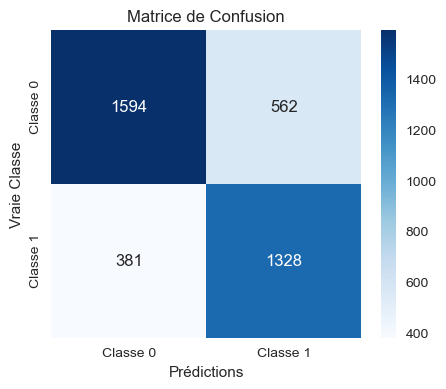

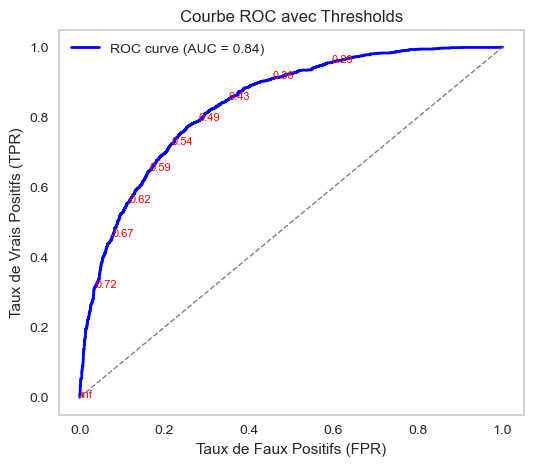

In [66]:
evaluate_model(best_rf_model, X_test, y_test)

In [113]:
from sklearn.neural_network import MLPClassifier

stratKfold = KFold(n_splits=4, shuffle=True, random_state=42)

# Grid Search pour optimiser l'hyperparamètre "C" (régularisation)
mlp_param_grid = {
    'model__hidden_layer_sizes': [(200, 50, 5,)],  # Nombre de neurones et couches cachées
    'model__activation': ['tanh'],  # Fonction d'activation
    'model__solver': ['adam'],  # Algorithme d'optimisation
    'model__alpha': [ 0.001],  # Régularisation L2
    'model__learning_rate': ['adaptive'],  # Stratégie de mise à jour du learning rate
    'model__learning_rate_init': [0.001],  # Taux d'apprentissage initial
    'model__max_iter': [200],  # Nombre d'itérations (epochs)
    'model__batch_size': [128],  # Taille du mini-batch
    'model__early_stopping': [True],  # Arrêt anticipé pour éviter l'overfitting
}

mlp_pipeline = make_pipeline(MLPClassifier(random_state=42))

grid_search = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=stratKfold, refit='r2', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)
# grid_search = RandomizedSearchCV(mlp_pipeline, mlp_param_grid, cv=stratKfold, n_iter=50, refit='neg_root_mean_squared_error', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Meilleur modèle
mlp_best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Meilleurs paramètres : {'model__activation': 'tanh', 'model__alpha': 0.001, 'model__batch_size': 128, 'model__early_stopping': True, 'model__hidden_layer_sizes': (200, 50, 5), 'model__learning_rate': 'adaptive', 'model__learning_rate_init': 0.001, 'model__max_iter': 200, 'model__solver': 'adam'}


In [111]:

pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()


,0
mean_fit_time,14.124611
std_fit_time,1.391364
mean_score_time,0.078097
std_score_time,0.008063
param_model__activation,tanh
param_model__alpha,0.001
param_model__batch_size,128
param_model__early_stopping,True
param_model__hidden_layer_sizes,"(200, 100, 50, 5)"
param_model__learning_rate,adaptive


🔹 R² Score: 0.0308
🔹 MAE: 0.2391
🔹 MSE: 0.2391

📊 Rapport de Classification:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      2156
           1       0.73      0.72      0.73      1709

    accuracy                           0.76      3865
   macro avg       0.76      0.76      0.76      3865
weighted avg       0.76      0.76      0.76      3865



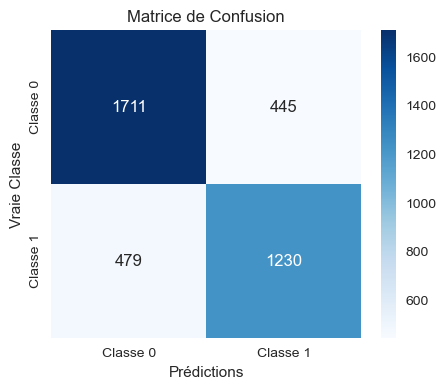

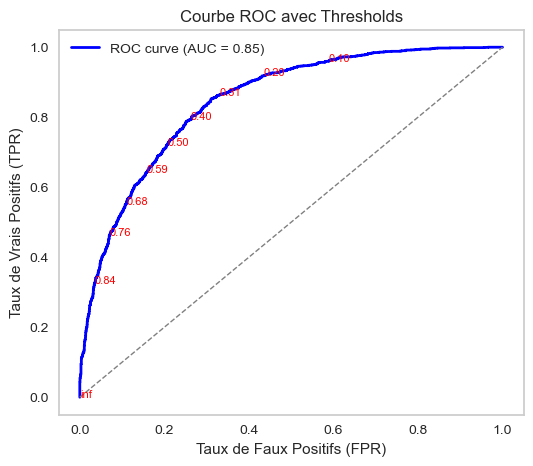

In [114]:
evaluate_model(mlp_best_model, X_test, y_test)

In [96]:
from sklearn.ensemble import GradientBoostingClassifier


stratKfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search pour optimiser l'hyperparamètre "C" (régularisation)
gb_param_grid = {
    'model__n_estimators': [100],  # Nombre d'arbres
    'model__learning_rate': [0.01],  # Taux d'apprentissage
    'model__max_depth': [10, 20],  # Profondeur maximale des arbres
    'model__min_samples_split': [5, 10],  # Nombre min d'échantillons pour diviser un nœud
    'model__min_samples_leaf': [2, 5],  # Nombre min d'échantillons dans une feuille
    'model__max_features': ['sqrt'],  # Nombre max de features utilisées pour chaque split
    'model__subsample': [0.7],  # Fraction des données utilisées par arbre
}

gb_pipeline = make_pipeline(GradientBoostingClassifier(random_state=42))

grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=stratKfold, refit='r2', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)
# grid_search = RandomizedSearchCV(gb_pipeline, gb_param_grid, cv=stratKfold, n_iter=50, refit='neg_root_mean_squared_error', scoring=['r2','neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Meilleur modèle
gb_best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres : {'model__learning_rate': 0.01, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'model__subsample': 0.7}


In [97]:

pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()


,4,5,6,7,1,0,2,3
mean_fit_time,9.22224,8.39978,6.208585,6.195654,3.441637,3.653753,2.925943,2.925906
std_fit_time,0.070264,0.120468,0.067955,0.065964,0.082111,0.062149,0.032785,0.042493
mean_score_time,0.153986,0.165738,0.200285,0.1817,0.159284,0.181065,0.156455,0.172471
std_score_time,0.004257,0.00138,0.005449,0.01211,0.003448,0.000829,0.004225,0.003973
param_model__learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_model__max_depth,20,20,20,20,10,10,10,10
param_model__max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_model__min_samples_leaf,2,2,5,5,2,2,5,5
param_model__min_samples_split,5,10,5,10,10,5,5,10
param_model__n_estimators,100,100,100,100,100,100,100,100


🔹 R² Score: 0.0024
🔹 MAE: 0.2461
🔹 MSE: 0.2461

📊 Rapport de Classification:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      2156
           1       0.75      0.66      0.70      1709

    accuracy                           0.75      3865
   macro avg       0.75      0.74      0.75      3865
weighted avg       0.75      0.75      0.75      3865



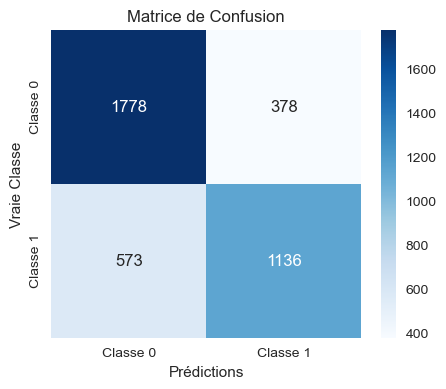

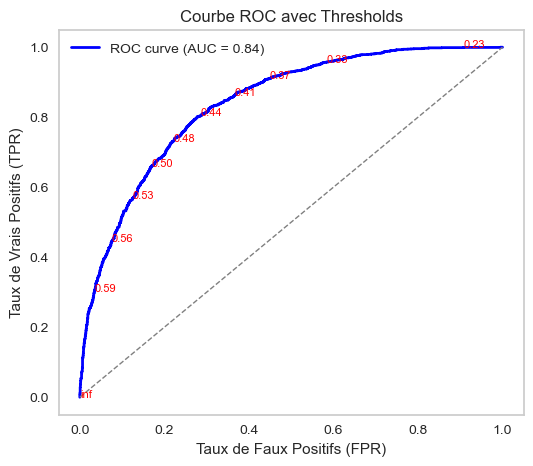

In [108]:
evaluate_model(gb_best_model, X_test, y_test)

## 7. Sur-modèle ensembliste


In [123]:
preprocessor = make_pipeline("passthrough").named_steps["preprocessor"]
X_train_transformed = preprocessor.fit_transform(X_train)

print("Type de sortie du préprocesseur:", type(X_train_transformed))
print("Shape de X_train_transformed:", X_train_transformed.shape)

if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    print("Conversion en array effectuée.")

print("Nouveau type après conversion:", type(X_train_transformed))


Type de sortie du préprocesseur: <class 'scipy.sparse._csr.csr_matrix'>
Shape de X_train_transformed: (15459, 243)
Conversion en array effectuée.
Nouveau type après conversion: <class 'numpy.ndarray'>


In [129]:


from sklearn.ensemble import StackingClassifier


# mlp = Pipeline([
#     ('scaler', StandardScaler()),  # MLP est sensible aux échelles de features
#     ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
#                            max_iter=300, batch_size=256, early_stopping=True, random_state=42))
# ])

# Création du modèle Stacking

stackin_pipeline = Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features), 
            ("cat", Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')), 
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features), 
            ("ord", Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder(categories=ordinal_categories)) 
            ]), ordinal_features)
        ], sparse_threshold= 0)),
        # ("to_dense", FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)), 
        ("stacking", StackingClassifier(
            estimators=[
                ('rf', best_rf_model),
                ('gb', gb_best_model)],
            # final_estimator=mlp,
            passthrough=False,  # Permet d'ajouter X original au meta-modèle
            n_jobs=-1,  # Utilise tous les cœurs CPU
            verbose=1
        ))
])


stackin_pipeline.fit(X_train, y_train)



ValueError: Specifying the columns using strings is only supported for dataframes.